In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from scipy.optimize import curve_fit
import math

In [2]:
red = '#e64b35'
blue='#4dbbd5'

In [3]:
def df_process(filepath):

    df = pd.read_csv(filepath, header=[0,1], index_col=0)

    # Prepare data
    df.index.name = 'Sample'
    df.columns.names = ['Replicate', 'Wavelength']
    df_long = df.stack(level='Replicate').reset_index()
    df_long['replicate'] = df_long['Replicate'].str.extract(r'rep(\d+)').astype(int)
    df_long = df_long.drop(columns=['Replicate'])

    # Sort by replicate (1, then 2, then 3) and Sample within each group
    df_long = df_long.sort_values(['replicate', 'Sample']).reset_index(drop=True)

    return df_long

In [4]:
base_dirs = ['20250725_1131']
# 

pattern = re.compile(
    r'^CAPB_'                 # 固定前缀
    r'(?P<time>\d+)min_'      # 数字 + "min_"
    r'(?P<assay>[abc])'       # 只允许 a, b, c
    r'_raw_multiindex\.csv$'  # 严格匹配 ".csv" 并用 $ 尾
)


# 1) Read & combine output_data
out_dfs = []
for base in base_dirs:
    for path in (Path(base) / 'raw_data').glob('*.csv'):
        m = pattern.match(path.name)
        if not m:
            continue

        t    = int(m.group('time'))
        assay  = m.group('assay')


        df = df_process(path)
#        df['ratio']      = df['334_373'] / df['334_384']

        df['assay']      = assay
        df['time']        = t

        out_dfs.append(df)

combined_raw = pd.concat(out_dfs, ignore_index=True)

combined_raw

/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_45165/545807913.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_long = df.stack(level='Replicate').reset_index()
/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_45165/545807913.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_long = df.stack(level='Replicate').reset_index()
/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_45165/545807913.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New n

Wavelength,Sample,334_373,334_384,replicate,assay,time
0,D1,109894.0,132898.0,1,c,20
1,D2,130943.0,157137.0,1,c,20
2,D3,130320.0,157032.0,1,c,20
3,D4,123992.0,155677.0,1,c,20
4,D5,118330.0,148677.0,1,c,20
...,...,...,...,...,...,...
535,D8,133659.0,178963.0,3,c,0
536,E1,124160.0,172875.0,3,c,0
537,E2,139325.0,191553.0,3,c,0
538,E3,141145.0,194804.0,3,c,0


In [5]:
max_conc = 50
estimate_cmc = 0.627
number_of_points = 12

max_conc = max_conc * 0.8  # Allowing for a bit of extra space
low = estimate_cmc / (50**0.5)
high = estimate_cmc * (50**0.5)

if high > max_conc:
    print(f"Warning: High concentration {high} exceeds maximum stock concentration {max_conc}. Adjusting high to max stock concentration.")
    high = max_conc


exponent_low = np.round(np.log10(low), 3)
exponent_high = np.round(np.log10(high), 3)
concentrations = np.round(np.logspace(exponent_low, exponent_high, number_of_points), 3)

concentrations

array([0.089, 0.127, 0.181, 0.258, 0.368, 0.525, 0.749, 1.07 , 1.526,
       2.178, 3.108, 4.436])

In [12]:
import numpy as np

# 1. 计算需要重复的次数
total_rows = combined_raw.shape[0]            # 540
n_conc    = len(concentrations)               # 12
reps      = total_rows // n_conc              # 45

# 2. 把整个 concentrations 数组重复 reps 次
conc_repeated = np.tile(concentrations, reps)  # 长度 = 12 * 45 = 540

# （可选：如果 540 不是 12 的整数倍，可以这样截断或补齐）
# conc_repeated = np.tile(concentrations, reps + 1)[:total_rows]

# 3. 赋值回 DataFrame
combined_raw['concentration'] = conc_repeated
combined_raw['surfactant'] = 'CAPB'
combined_raw['ratio'] = combined_raw['334_373'] / combined_raw['334_384']
combined_raw



Wavelength,Sample,334_373,334_384,replicate,assay,time,conc,surfactant,ratio,concentration
0,D1,109894.0,132898.0,1,c,20,0.089,CAPB,0.826905,0.089
1,D2,130943.0,157137.0,1,c,20,0.127,CAPB,0.833305,0.127
2,D3,130320.0,157032.0,1,c,20,0.181,CAPB,0.829895,0.181
3,D4,123992.0,155677.0,1,c,20,0.258,CAPB,0.796470,0.258
4,D5,118330.0,148677.0,1,c,20,0.368,CAPB,0.795886,0.368
...,...,...,...,...,...,...,...,...,...,...
535,D8,133659.0,178963.0,3,c,0,1.070,CAPB,0.746853,1.070
536,E1,124160.0,172875.0,3,c,0,1.526,CAPB,0.718207,1.526
537,E2,139325.0,191553.0,3,c,0,2.178,CAPB,0.727344,2.178
538,E3,141145.0,194804.0,3,c,0,3.108,CAPB,0.724549,3.108


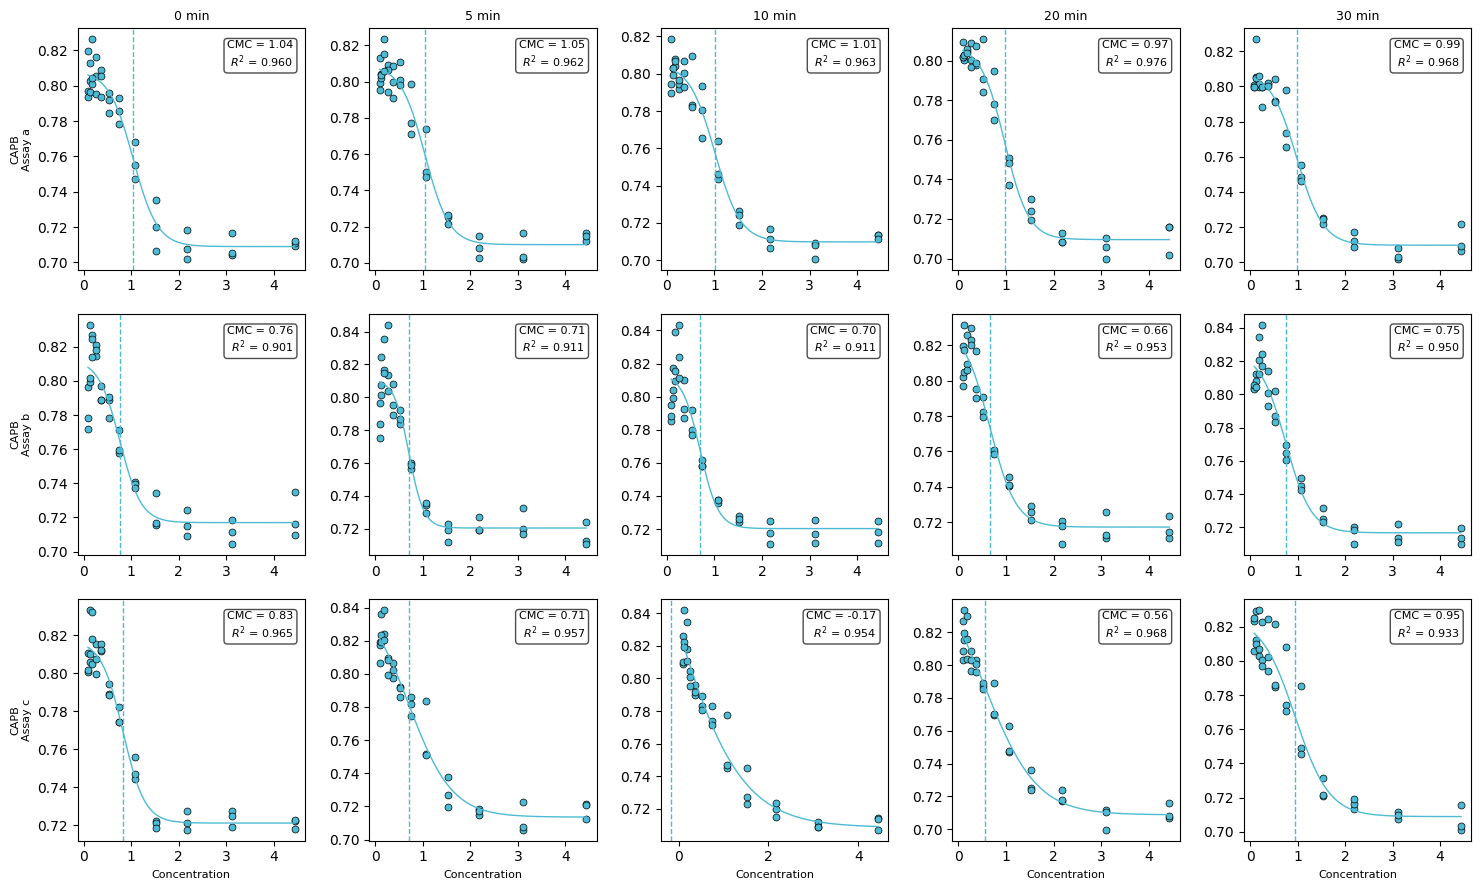

In [22]:
# Boltzmann sigmoidal function
def boltzmann(x, A1, A2, x0, dx):
    return A2 + (A1 - A2) / (1 + np.exp((x - x0) / dx))

# CMC_plot function as provided
def CMC_plot(ax, ratio, conc ,log=0, plot=1):

    if log:
        conc = np.log(conc)

    p0 = [
        max(ratio),
        min(ratio),
        (max(conc) + min(conc)) / 2,
        (max(conc) - min(conc)) / 5
    ]
    popt, _ = curve_fit(boltzmann, conc, ratio, p0, maxfev=5000)
    A1, A2, x0, dx = popt

    # compute R²
    residuals = ratio - boltzmann(conc, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ratio - np.mean(ratio))**2)
    r2 = 1 - ss_res / ss_tot

    if plot:
        # generate fit curve
        x_fit = np.linspace(min(conc), max(conc), 200)

        # scatter with blue face and thin black edge
        ax.scatter(
            conc, ratio,
            s=25,
            facecolors=blue,
            edgecolors='black',
            linewidth=0.5,
            label='Data'  # optional
        )

        # fitted Boltzmann curve in blue
        ax.plot(
            x_fit,
            boltzmann(x_fit, *popt),
            color=blue,
            lw=1,
            label='Fit'   # optional
        )

        # vertical CMC line in blue
        ax.axvline(
            x0,
            linestyle='--',
            color=blue,
            lw=1,
            label='CMC'   # optional
        )

        if log:
            x0 = math.exp(x0)

        # annotate stats
        ax.text(
            0.95, 0.95,
            f"CMC = {x0:.2f}\n$R^2$ = {r2:.3f}",
            transform=ax.transAxes, ha='right', va='top',
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", fc="white",
                    ec="black", alpha=0.7)
        )
    return x0, r2

COMBINE_ASSAYS = False   # ← set True to combine all assays before fitting
# ————————————————————

# Load data
df = combined_raw.copy()

# Column mappings
I1_COL    = '334_373'
I3_COL    = '334_384'
RATIO_COL = 'ratio'
SURF_COL  = 'surfactant'
TIME_COL  = 'time'
ASSAY_COL = 'assay'
CONC_COL  = 'concentration'

# If needed:
# df[RATIO_COL] = df[I1_COL] / df[I3_COL]

# surfactant ordering
SURFACTANT_ORDER = ['CAPB']
df[SURF_COL] = pd.Categorical(df[SURF_COL],
                              categories=SURFACTANT_ORDER,
                              ordered=True)

times  = sorted(df[TIME_COL].unique())
assays = sorted(df[ASSAY_COL].unique())

# build combos depending on mode
if COMBINE_ASSAYS:
    combos = [(surf, None) for surf in SURFACTANT_ORDER]
else:
    combos = [
        (surf, assay)
        for surf in SURFACTANT_ORDER
        for assay in assays
        if not df[(df[SURF_COL] == surf) & (df[ASSAY_COL] == assay)].empty
    ]

n_rows = len(combos)
n_cols = len(times)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols*3, n_rows*3),
                         sharex=False, sharey=False)

for i, (surf, assay) in enumerate(combos):
    for j, t in enumerate(times):
        ax = axes[i, j] if n_rows>1 and n_cols>1 else axes[max(i,j)]

        # pick subset depending on mode
        if COMBINE_ASSAYS:
            subset = df[(df[SURF_COL]==surf) & (df[TIME_COL]==t)]
        else:
            subset = df[(df[SURF_COL]==surf) &
                        (df[ASSAY_COL]==assay) &
                        (df[TIME_COL]==t)]

        if not subset.empty:
            CMC_plot(ax,
                     subset[RATIO_COL].values,
                     subset[CONC_COL].values,
                     log=0, plot=1)
        else:
            ax.axis('off')

        # titles/labels
        if i == 0:
            ax.set_title(f"{t} min", fontsize=9)

        if j == 0:
            if COMBINE_ASSAYS:
                ax.set_ylabel(f"{surf}", fontsize=8)
            else:
                ax.set_ylabel(f"{surf}\nAssay {assay}", fontsize=8)

        if i == n_rows - 1:
            ax.set_xlabel("Concentration", fontsize=8)

plt.tight_layout()
#fig.savefig('Figure_2.png', dpi=300)
plt.show()
